In [38]:
import pandas as pd
import re
import nltk

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# Ідеї

*Отже, так, як у нас немає як такої оцінки коментарів, я вирішив трішки почитати самі коментарі(вибірково) та придумати приблизно, як можна їх оцінити. То ж, я помітив, що позитивні коментарі у нас, зазвичай мають score 5, нейтральні 4, а негативні, на які варто звернути увагу 1,2,3. Тому ми візьмемо score як таргет змінну та будемо працювати з нею.*

# Data

In [39]:
prtgs_stopwords = stopwords.words('portuguese')

In [40]:
raw_data = pd.read_csv('data/order_reviews.csv')[['review_comment_message', 'review_score']]

In [41]:
raw_data

,review_comment_message,review_score
0,NaN,4
1,NaN,5
2,NaN,5
3,Recebi bem antes do prazo estipulado.,5
4,Parabéns lojas lannister adorei comprar pela I...,5
...,...,...
99995,NaN,5
99996,"Excelente mochila, entrega super rápida. Super...",5
99997,NaN,4
99998,Solicitei a compra de uma capa de retrovisor c...,1


# Functions

In [42]:
def conf_matrix(y_test, y_pred):
    fig, axs = plt.subplots(1, 3, figsize=(30, 10))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot(ax=axs[0])
    axs[0].set_title('Confusion Matrix')
    
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true')).plot(ax=axs[1])
    axs[1].set_title('Matrix by Recall')
    
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='pred')).plot(ax=axs[2])
    axs[2].set_title('Matrix by Precision')

# EDA

In [43]:
raw_data.isna().sum()

review_comment_message    58247
review_score                  0
dtype: int64

In [44]:
raw_data.head(5)

,review_comment_message,review_score
0,NaN,4
1,NaN,5
2,NaN,5
3,Recebi bem antes do prazo estipulado.,5
4,Parabéns lojas lannister adorei comprar pela I...,5


In [45]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   review_comment_message  41753 non-null   object
 1   review_score            100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


<Axes: xlabel='review_score', ylabel='count'>

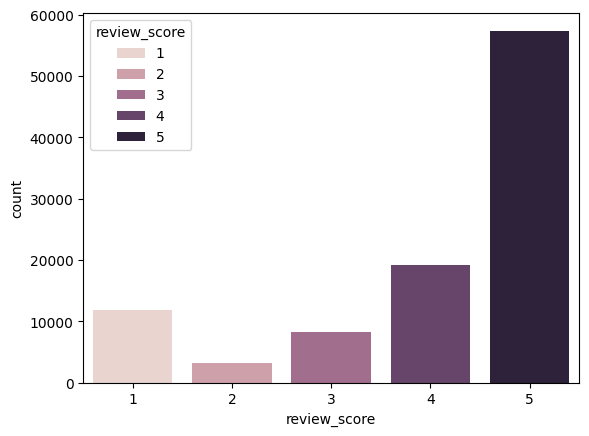

In [46]:
sns.countplot(data=raw_data, x='review_score', hue='review_score')

*Тут нам потрібно видалити дані, де немає коментарів. Також, збалансувати класи та обробити текст*  
*Використаємо очистку від тегів, розділових знаків, посилань, зробимо всі коменти з маленької букви, видалимо стоп слова, та й цього має бути достатньо*

# Text preprocessing

In [47]:
def rating_to_sentiment(rating):
    if rating == 5:
        return 'Позитивний'
    elif rating == 4:
        return 'Нейтральний'
    else:
        return 'Негативний'

In [48]:
prtgs_stopwords = stopwords.words('portuguese')

def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('<[^<]+?>', '', text)
    text = re.sub(r'http\S+', '', text)

    text = text.lower()
    
    words = text.split()

    stemmer = SnowballStemmer("portuguese")

    processed_text = [stemmer.stem(word) for word in words if word not in prtgs_stopwords]

    processed_text = ' '.join(processed_text)
    
    return processed_text


In [49]:
raw_data.isna().sum()

review_comment_message    58247
review_score                  0
dtype: int64

In [50]:
raw_data.dropna(inplace=True)

In [51]:
raw_data['review_comment_message'] = raw_data['review_comment_message'].apply(remove_punctuation)

In [52]:
raw_data

,review_comment_message,review_score
3,receb bem antes praz estipul,5
4,parabéns loj lannist ador compr internet segur...,5
9,aparelh eficient sit marc aparelh impress 3des...,4
12,pouc travandopel valor ta boa,4
15,vendedor confiável produt ok entreg antes praz,5
...,...,...
99983,entreg dentr praz produt cheg condiçõ perfeit ...,5
99990,produt envi nf exist vend nf certez fic aguard...,3
99996,excelent mochil entreg sup ráp sup recom loj,5
99998,solicit compr cap retrovisor celtaprismamer pr...,1


In [53]:
raw_data['review_score'] = raw_data['review_score'].apply(rating_to_sentiment)

<Axes: xlabel='review_score', ylabel='count'>

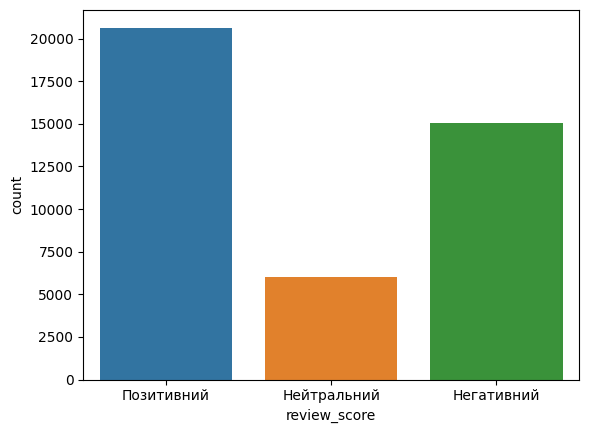

In [56]:
sns.countplot(data=raw_data, x='review_score', hue='review_score')

*Маємо незбалансовані дані. Думаю це побороти RandomForestClassifier, та його властивістю class_weight='balanced'*

In [57]:
X = raw_data['review_comment_message']
y = raw_data['review_score']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [60]:
vectorize = TfidfVectorizer()
X_train_TF = vectorize.fit_transform(X_train)
X_test_TF = vectorize.transform(X_test)

In [66]:
param_grid = {
    'n_estimators': [800],
    'criterion': ['log_loss'],
    'max_depth': [100], 
    'min_samples_split': [10],  
    'min_samples_leaf': [2]  
}
class_weights = {'Позитивний': 1, 'Нейтральний': 3, 'Негативний': 1}
# param_grid = {
#     'n_estimators': [100, 500, 800],
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'max_depth': [10, 50, 100], 
#     'min_samples_split': [2, 5, 10],  
#     'min_samples_leaf': [1, 2, 5]  
# }

RFC = GridSearchCV(estimator=RandomForestClassifier(class_weight=class_weights, random_state=42), refit=True, param_grid=param_grid, scoring='accuracy', cv=5, verbose=3, n_jobs=-1)
RFC.fit(X_train_TF, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={'Негативний': 1,
                                                            'Нейтральний': 3,
                                                            'Позитивний': 1},
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['log_loss'], 'max_depth': [50, 100],
                         'min_samples_leaf': [2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [800, 1000]},
             scoring='accuracy', verbose=3)

In [67]:
RFC.best_params_

{'criterion': 'log_loss',
 'max_depth': 100,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 800}

In [68]:
y_pred = RFC.predict(X_test_TF)

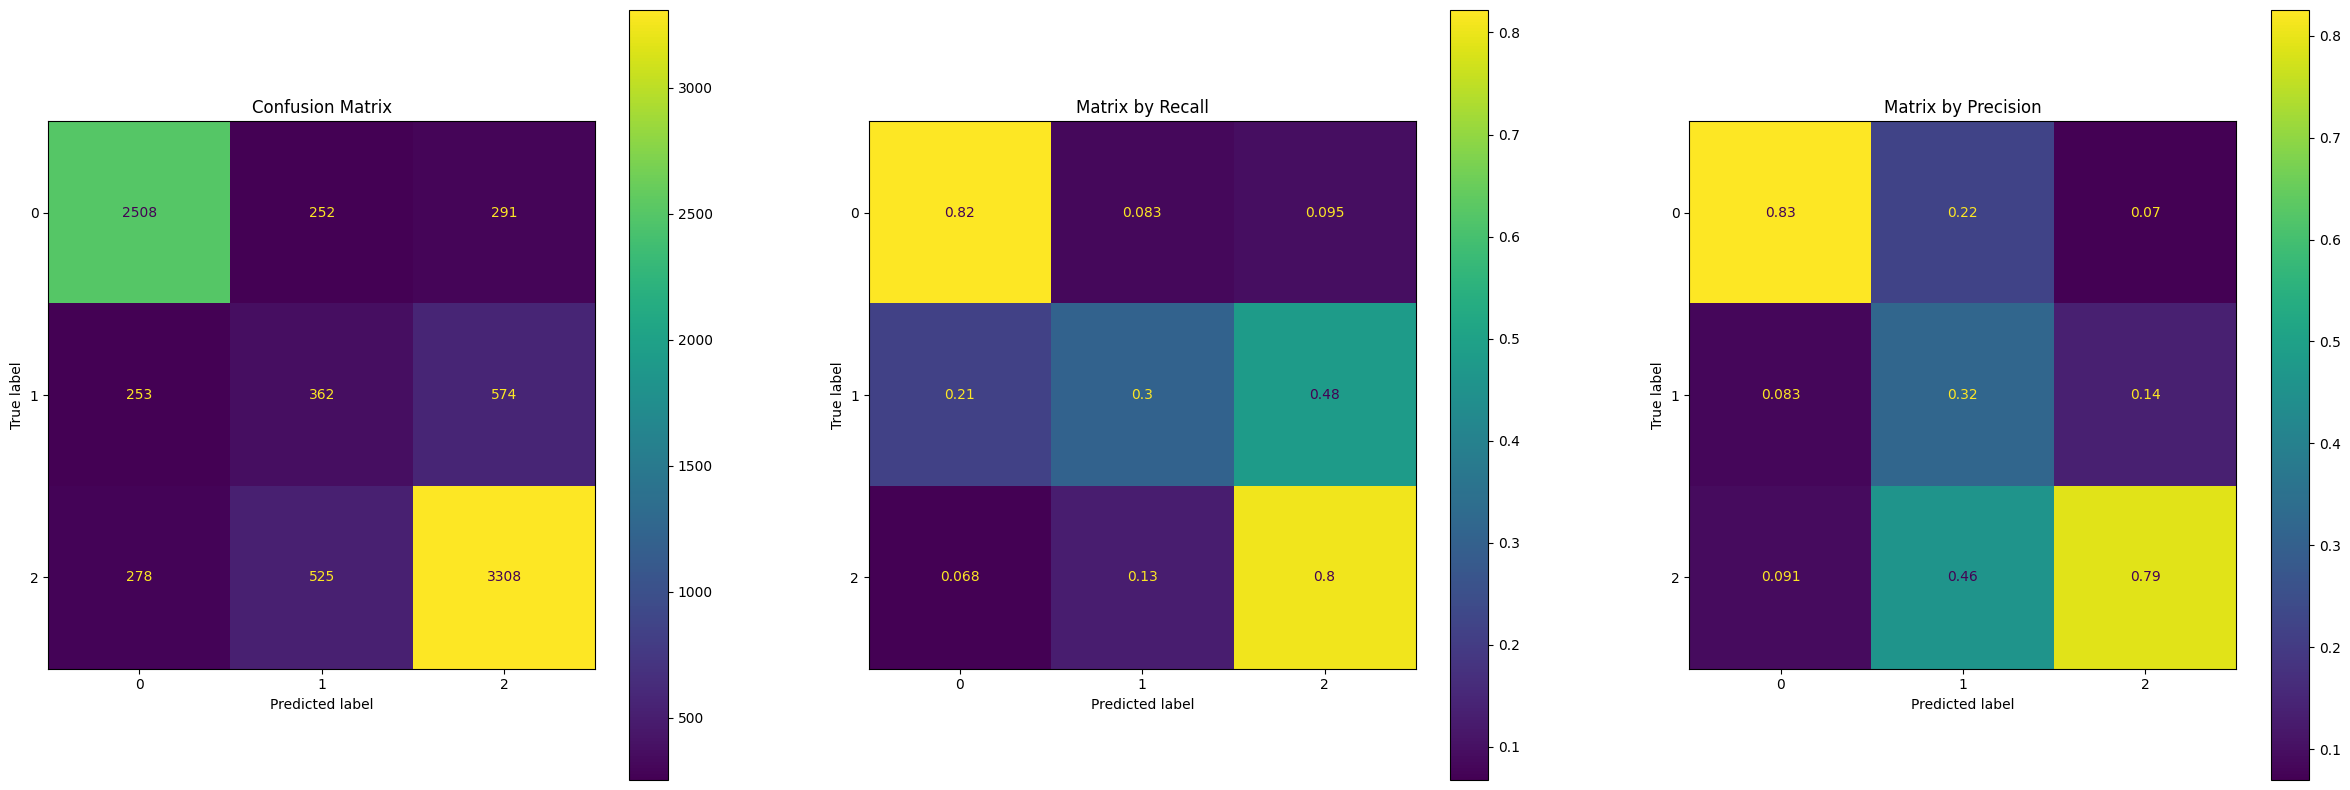

In [69]:
conf_matrix(y_test=y_test, y_pred=y_pred)

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Негативний       0.83      0.82      0.82      3051
 Нейтральний       0.32      0.30      0.31      1189
  Позитивний       0.79      0.80      0.80      4111

    accuracy                           0.74      8351
   macro avg       0.65      0.64      0.64      8351
weighted avg       0.74      0.74      0.74      8351



# Task 2

In [20]:
def price(text):
    pattern = r'(\$\s?\d+(\.\d{2})?)|(\d+\s?(escudos?|dólares?|euros?|€))'
    prices = re.findall(pattern, text)

    found_prices = []
    for price in prices:
        if price[0]:
            found_prices.append(price[0])
        elif price[2]:
            found_prices.append(price[2])
    
    if found_prices == []:
        return None
    else:
        return found_prices

In [21]:
a = 'The product costs $29.99 and it is very good!'
price(a)

['$29.99']

In [22]:
a = [
        'The product costs $29.99 and it is very good!',
        'I bought it for 150 escudos, but I am not satisfied.',
        'O produto custa $20, estou muito satisfeito.',
        'Comprei por 100 dólares e gostei muito.',
        'O preço do produto é 50€.',
        'Eu paguei 200 euros pelo produto.'
    ]
price(a[3])

['100 dólares']